<a href="https://colab.research.google.com/github/juneilsam/mariah_carey_christmas/blob/main/mariah_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 불러오기

In [17]:
filename = '/content/drive/MyDrive/mariah_xmas.csv'

In [18]:
df = pd.read_csv(filename, encoding = 'cp949')

In [19]:
df.info()
# 음원 순위는 i-tunes 기준
# 미국은 New-York 기준, 영국은 London 기준

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3608 non-null   int64  
 1   WDRank  3607 non-null   float64
 2   USRank  3562 non-null   float64
 3   USTemp  3608 non-null   float64
 4   UKRank  3553 non-null   float64
 5   UKTemp  3608 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 169.2 KB


In [20]:
df.head()

,date,WDRank,USRank,USTemp,UKRank,UKTemp
0,20110219,400.0,400.0,2.78,400.0,5.11
1,20110220,400.0,400.0,-0.78,400.0,4.72
2,20110221,400.0,400.0,-1.33,400.0,5.28
3,20110222,400.0,400.0,-3.72,400.0,6.11
4,20110223,400.0,400.0,-0.56,400.0,8.83


# 2.데이터 정제

In [21]:
# 데이터 형식 변환(숫자-날짜-인덱스)
df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d")
df = df.set_index('date')

2014년부터 2018년까지는 해당 곡에 일종의 '밈'이 작용하여 보다 빨리 순위에 진입하는 양상을 보임


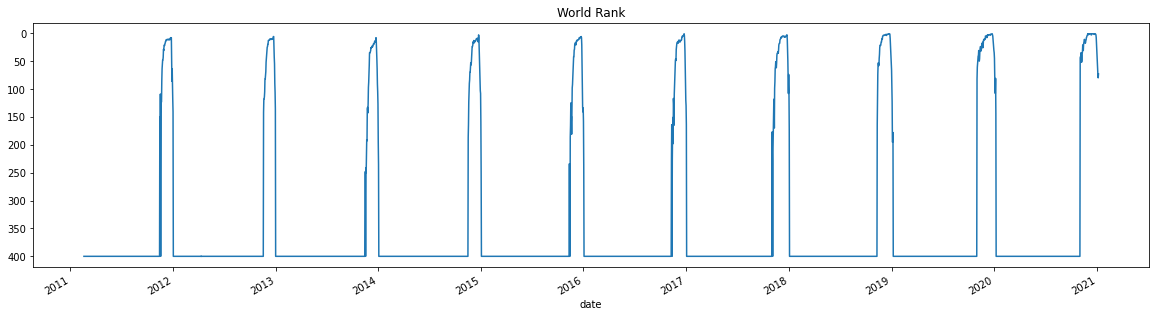

In [22]:
plt.figure(figsize=(20, 5))
df['WDRank'].plot()
plt.gca().invert_yaxis()
plt.title('World Rank')
print("2014년부터 2018년까지는 해당 곡에 일종의 '밈'이 작용하여 보다 빨리 순위에 진입하는 양상을 보임")

Text(0.5, 1.0, 'US, UK Rank')

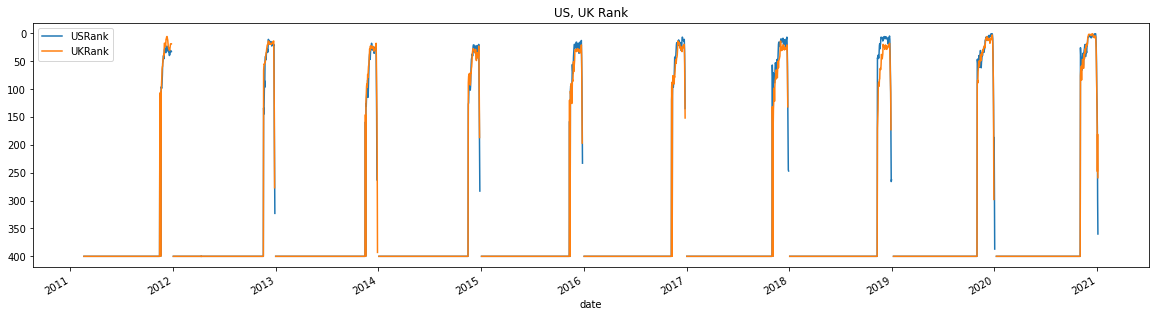

In [23]:
plt.figure(figsize=(20, 5))
df['USRank'].plot()
df['UKRank'].plot()
plt.legend()
plt.gca().invert_yaxis()
plt.title('US, UK Rank')

Text(0.5, 1.0, 'US, UK Temperature')

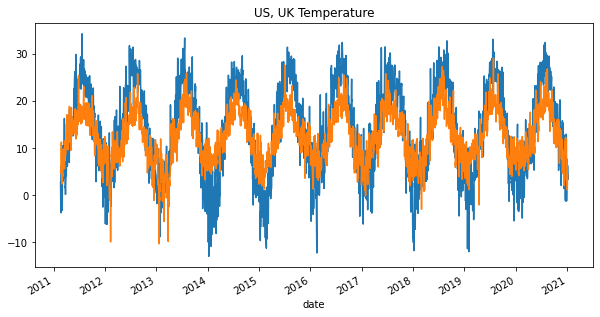

In [24]:
plt.figure(figsize=(10, 5))
df['USTemp'].plot()
df['UKTemp'].plot()
plt.title('US, UK Temperature')

In [25]:
# 결측치 변경
df = df.fillna(method='pad')

In [26]:
df.head()

,WDRank,USRank,USTemp,UKRank,UKTemp
date,,,,,
2011-02-19,400.0,400.0,2.78,400.0,5.11
2011-02-20,400.0,400.0,-0.78,400.0,4.72
2011-02-21,400.0,400.0,-1.33,400.0,5.28
2011-02-22,400.0,400.0,-3.72,400.0,6.11
2011-02-23,400.0,400.0,-0.56,400.0,8.83


In [27]:
df['WDRank'] = pd.to_numeric(df['WDRank'])
df['USRank'] = pd.to_numeric(df['USRank'])
df['UKRank'] = pd.to_numeric(df['UKRank'])

In [28]:
# 데이터 클렌징. 최대최소
df = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

In [ ]:
df

,WDRank,USRank,USTemp,UKRank,UKTemp
date,,,,,
2011-02-19,1.000000,1.000000,0.333333,1.000000,0.391205
2011-02-20,1.000000,1.000000,0.257846,1.000000,0.381291
2011-02-21,1.000000,1.000000,0.246183,1.000000,0.395526
2011-02-22,1.000000,1.000000,0.195505,1.000000,0.416624
2011-02-23,1.000000,1.000000,0.262511,1.000000,0.485765
...,...,...,...,...,...
2021-01-02,0.120301,0.744361,0.429813,0.451128,0.289527
2021-01-03,0.165414,0.899749,0.344996,0.646617,0.330452
2021-01-04,0.185464,0.899749,0.407549,0.646617,0.360193


# 3. 데이터 분리

### 3-1. train, test data 분리

In [31]:
# 날짜기준, 훈련데이터와 테스트데이터 분리
split_date = pd.Timestamp('2018-12-31')

train = df.loc[:split_date, :]
test = df.loc[split_date: , :]

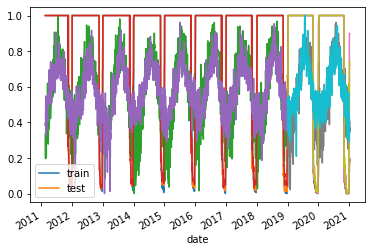

In [35]:
# 날짜기준, 훈련데이터와 테스트데이터 분리

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

## 3-2. Window 생성

In [36]:
# train data와 test data에서 값만을 추출
trainv = train.values
testv = test.values

# 90일치 데이터로 window 생성
lookback = 90 
X_train = []
X_test = []
y_train = []
y_test = []

# train data
for i in range(len(trainv) - lookback):
    X_train.append(trainv[i: i + lookback])
    y_train.append(trainv[i + lookback, [0]])

# test data
for j in range(len(testv) - lookback):
    X_test.append(testv[j: j + lookback])
    y_test.append(testv[j + lookback, [0]])

In [37]:
# numpy array로의 변환
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2781, 90, 5), (648, 90, 5), (2781, 1), (648, 1))

# 4. 데이터 훈련

In [55]:
# 데이터 training 지표 설정
model = Sequential()

model.add(LSTM(90, return_sequences = True, input_shape=(90, 5), activation = 'relu')) # LSTM을 거친다.
model.add(LSTM(64, return_sequences = False, activation = 'relu')) # 한 번 더

model.add(Dense(1)) # 값을 하나 구한다. 예측한 WDRank
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 90, 90)            34560     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                39680     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 74,305
Trainable params: 74,305
Non-trainable params: 0
_________________________________________________________________


In [56]:
# early_stop을 이용하여 조기에 학습이 완료될 시 종료될 수 있도록 함.
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

h = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 30, epochs = 200,  callbacks=[early_stop])

Epoch 1/200
93/93 [==============================] - 13s 115ms/step - loss: 0.1251 - acc: 0.6793 - val_loss: 0.0105 - val_acc: 0.8256
Epoch 2/200
93/93 [==============================] - 10s 106ms/step - loss: 0.0064 - acc: 0.8529 - val_loss: 0.0099 - val_acc: 0.8256
Epoch 3/200
93/93 [==============================] - 10s 106ms/step - loss: 0.0039 - acc: 0.8670 - val_loss: 0.0094 - val_acc: 0.8256
Epoch 4/200
93/93 [==============================] - 10s 109ms/step - loss: 0.0038 - acc: 0.8627 - val_loss: 0.0068 - val_acc: 0.8256
Epoch 5/200
93/93 [==============================] - 10s 106ms/step - loss: 0.0047 - acc: 0.8491 - val_loss: 0.0072 - val_acc: 0.8256
Epoch 6/200
93/93 [==============================] - 10s 107ms/step - loss: 0.0031 - acc: 0.8504 - val_loss: 0.0081 - val_acc: 0.8256
Epoch 7/200
93/93 [==============================] - 10s 107ms/step - loss: 0.0033 - acc: 0.8568 - val_loss: 0.0065 - val_acc: 0.8256
Epoch 8/200
93/93 [==============================] - 10s 106ms

# 5.예측값 확인

Text(0.5, 1.0, 'WDRank Prediction')

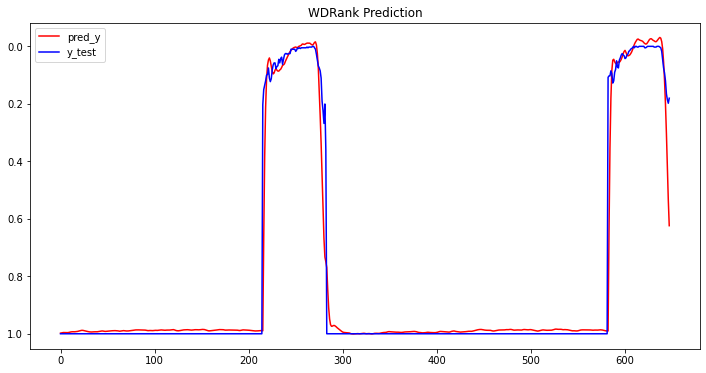

In [57]:
# 예측값 확인
pred_y = model.predict(X_test)

plt.figure(figsize=[12, 6])
plt.plot(pred_y.ravel(), 'r-', label='pred_y')
plt.plot(y_test.ravel(), 'b-', label='y_test')
plt.gca().invert_yaxis()
plt.legend()
plt.title('WDRank Prediction')

Text(0.5, 1.0, 'Loss')

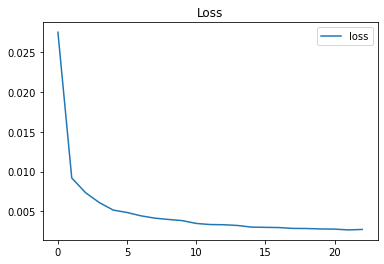

In [ ]:
plt.plot(h.history['loss'], label = 'loss')
plt.legend() # 우측 상단 파란선
plt.title('Loss')